In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch

torch.cuda.set_device(0)
torch.cuda.current_device()

import warnings
from pathlib import Path
from wrappers.transformer_wrapper import FairseqTransformerHub

import alignment.align as align

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

import logging
logger = logging.getLogger()

logger.setLevel('WARNING')
warnings.simplefilter('ignore')

from dotenv import load_dotenv
load_dotenv()
device = "cuda" if torch.cuda.is_available() else "cpu"

## Load model

In [3]:
data_sample = 'interactive' # generate/interactive
teacher_forcing = True # teacher forcing/free decoding

green_color = '#82B366'
red_color = '#B85450'

In [4]:
# Paths
europarl_dir = Path(os.environ['EUROPARL_DATA_DIR'])
ckpt_dir = Path(os.environ['EUROPARL_CKPT_DIR'])
#iwslt14_dir = Path(os.environ['IWSLT14_DATA_DIR'])
#ckpt_dir = Path(os.environ['IWSLT14_CKPT_DIR'])

# Choose model
model_type = 'baseline'
seed = 5498 # 2253  2453  5498  9240	9819

hub = FairseqTransformerHub.from_pretrained(
    ckpt_dir / f"{model_type}/{seed}",
    checkpoint_file=f"checkpoint_best.pt",
    data_name_or_path=(europarl_dir / "processed_data/fairseq_preprocessed_data").as_posix(), # processed data
    #(data_name_or_path=iwslt14_dir / "data-bin").as_posix(),
)
NUM_LAYERS = 6


## Get sample for analysis

In [5]:
# Get sample from provided test data

if data_sample == 'generate':
    i = 421 # 0, 1 28, 45, 148 (pred_tok vs tgt_tok), 178, 16 (Hallucination)

    src_sent, src_tok, src_tensor, tgt_sent, tgt_tok, tgt_tensor = hub.get_sample('test', i)
    print(f"\nSource sentence: \t {src_sent}")
    print(f"Target sentence: \t {tgt_sent}")

In [6]:
if data_sample == 'interactive':
    # Get sample from Gold alignment dataset

    # index in dataset
    i = 120 # index in dataset
    # 3, 100, 105, 107, 120 (example paper), 163 (error visible)
    test_set_dir = europarl_dir / "processed_data/"
    src = "de"
    tgt = "en"
    tokenizer = "bpe"
    src_word_sent, src_tok, src_tok_str, src_tensor, tgt_word_sent, tgt_tok, tgt_tok_str, tgt_tensor = hub.get_interactive_sample(i, test_set_dir, src, tgt, tokenizer, hallucination=False)

    print(src_word_sent)
    print(tgt_word_sent)

damit ist unsere aussprache über den stand der europäischen union geschlossen .

the debate on the state of the european union is closed .



### Teacher Forcing

In [7]:
if teacher_forcing:
    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print("\n\nGREEDY DECODING\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
    pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")

    source_sentence = src_tok
    target_sentence = tgt_tok
    predicted_sentence = pred_tok





GREEDY DECODING

Predicted sentence: 	 that debate on the state of the european union is closed .


In [8]:
if not teacher_forcing:
    tgt_tensor_free = []
    print("\n\nBEAM SEARCH\n")
    for pred in hub.generate(src_tensor, 5):
        tgt_tensor_free.append(pred['tokens'])
        pred_sent = hub.decode(pred['tokens'], hub.task.tgt_dict, as_string=True)
        score = pred['score'].item()
        print(f"{score} \t {pred_sent}")

    hypo = 0 # first hypothesis
    tgt_tensor = tgt_tensor_free[hypo]
    
    # We add eos token at the beginning of sentence and delete it from the end
    tgt_tensor = torch.cat([torch.tensor([hub.task.tgt_dict.eos_index]).to(tgt_tensor.device),
                    tgt_tensor[:-1]
                ]).to(tgt_tensor.device)
    tgt_tok = hub.decode(tgt_tensor, hub.task.tgt_dict, as_string=False)
    target_sentence = tgt_tok
    source_sentence = src_tok

    model_output, log_probs, encoder_out, layer_inputs, layer_outputs = hub.trace_forward(src_tensor, tgt_tensor)

    print(f"\n\nGREEDY DECODING with hypothesis {hypo+1}\n")
    pred_log_probs, pred_tensor = torch.max(log_probs, dim=-1)
    pred_tok = hub.decode(pred_tensor, hub.task.tgt_dict)
    pred_sent = hub.decode(pred_tensor, hub.task.tgt_dict, as_string=True)
    print(f"Predicted sentence: \t {pred_sent}")
    predicted_sentence = pred_tok

In [9]:
probs = torch.nn.functional.softmax(log_probs, dim=-1)
print('probs',probs.size())
pred_ind = torch.argmax(probs,dim=-1)
print(pred_ind.size())
pred = torch.max(probs,dim=-1)
pred


probs torch.Size([13, 10001])
torch.Size([13])


torch.return_types.max(
values=tensor([0.7155, 0.4967, 0.7094, 0.8452, 0.7540, 0.9014, 0.8613, 0.8553, 0.8980,
        0.8889, 0.7860, 0.8912, 0.9014], device='cuda:0'),
indices=tensor([ 645,  609,   64,    8,  550,   27,    8,  128,  248,   54, 2148,   24,
           2], device='cuda:0'))

### ALTI of the entire model

In [17]:
total_rollout = hub.get_contribution_rollout(src_tensor, tgt_tensor, 'l1', norm_mode='min_sum')['total']

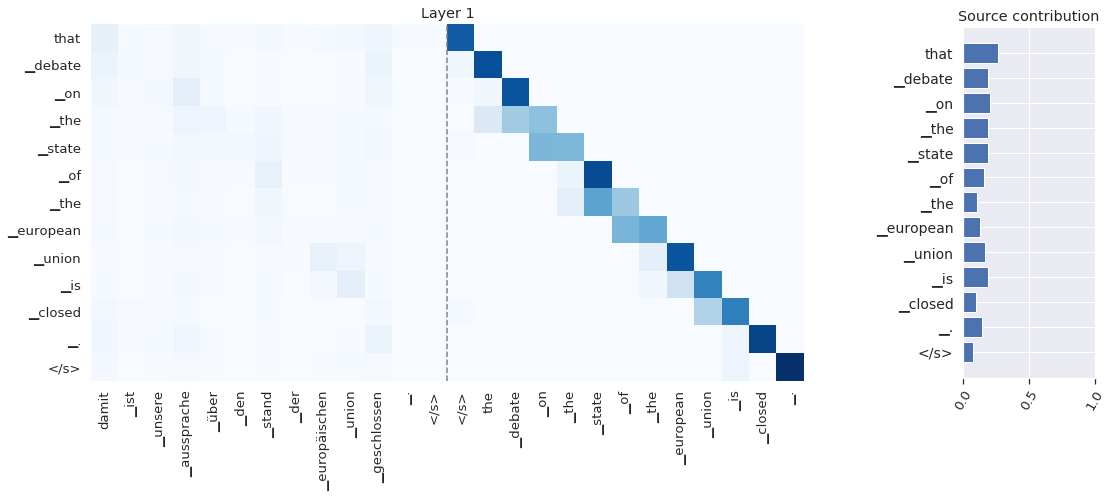

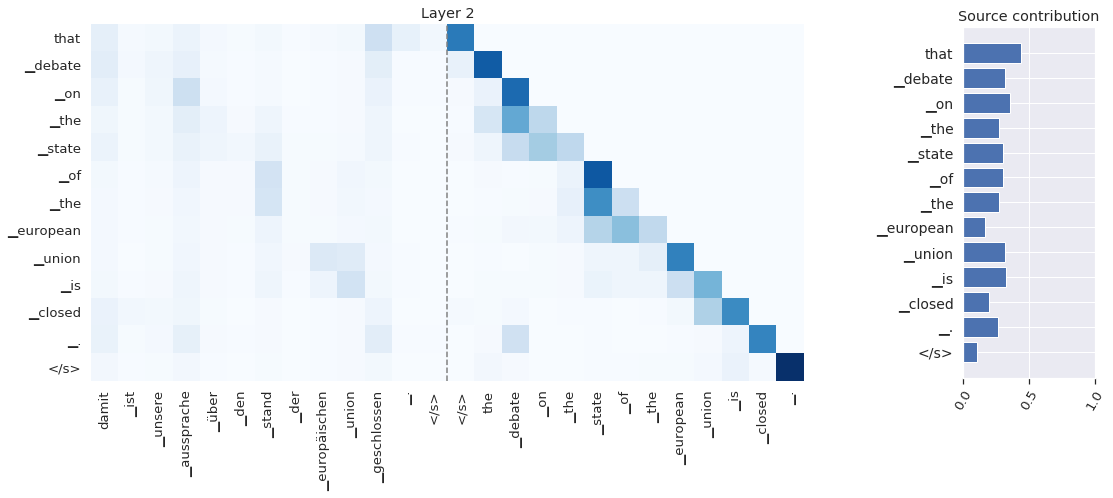

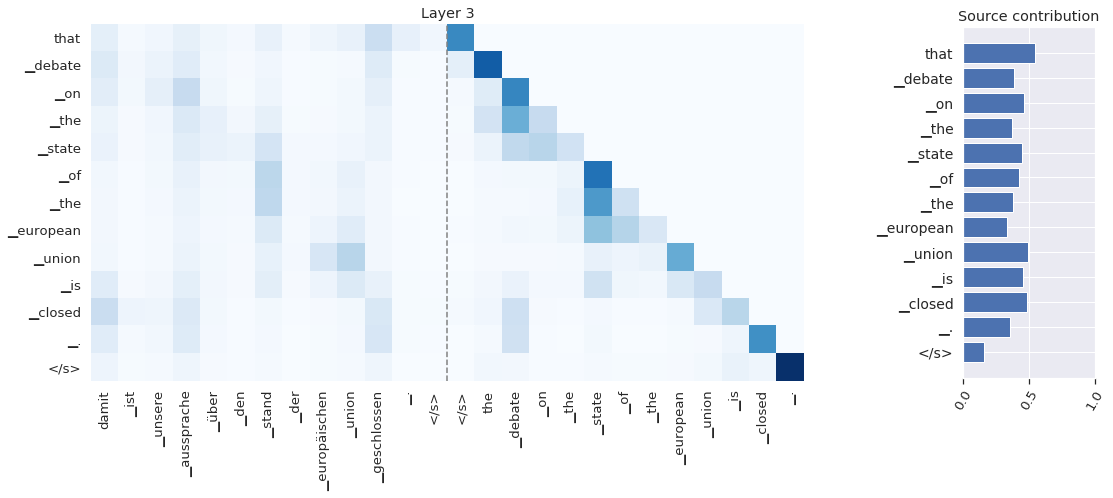

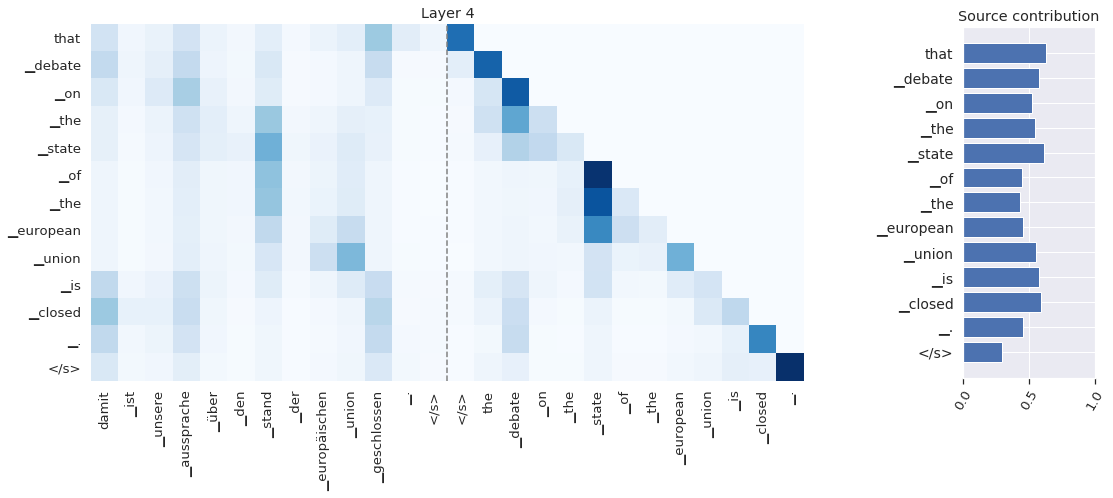

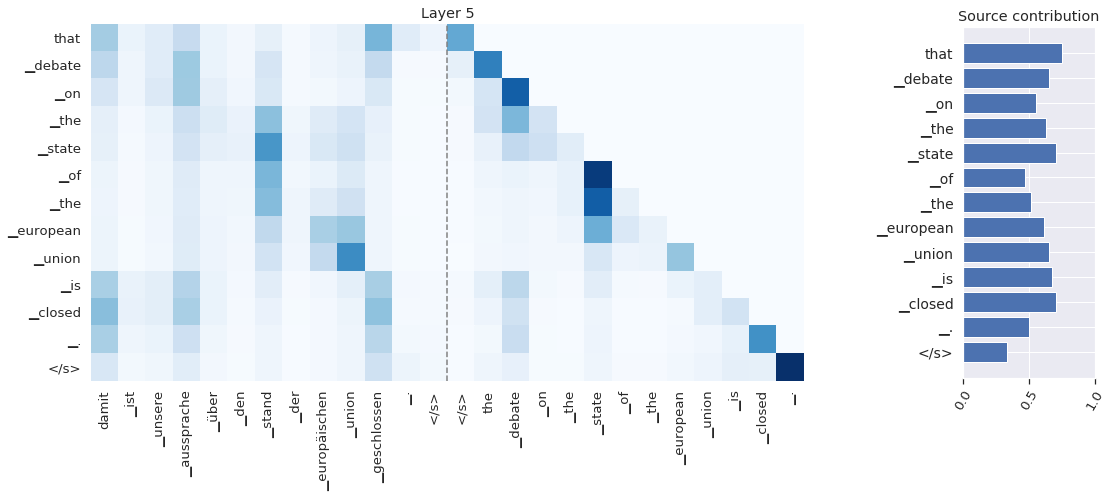

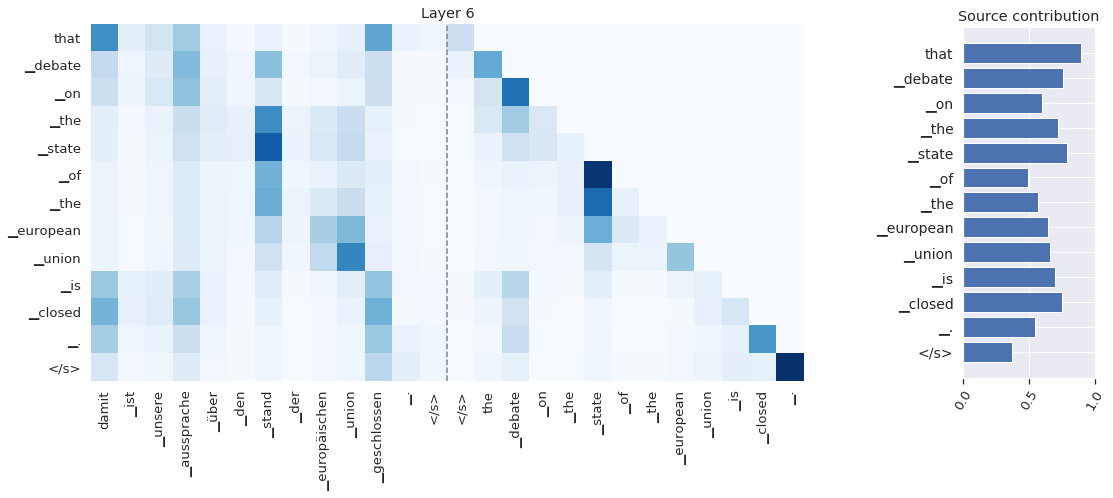

In [18]:
from matplotlib.gridspec import GridSpec

for layer in range(0,NUM_LAYERS):

    fig = plt.figure(figsize=(18, 20))
    gs = GridSpec(3, 4)
    gs.update(wspace=1.2, hspace=0.05)#0.015
    ax_main = plt.subplot(gs[0:3, :3])
    ax_yDist = plt.subplot(gs[1, 3])#, sharey=ax_main)
    
    contributions_rollout_layer = total_rollout[layer]
    contributions_rollout_layer_np = contributions_rollout_layer.detach().cpu().numpy()
    df = pd.DataFrame(contributions_rollout_layer_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
    sns.set(font_scale=1.2)
    sns.heatmap(df,cmap="Blues",square=True,ax=ax_main,cbar=False)#Reds,center=0
    src_contribution = contributions_rollout_layer_np[:,:len(src_tok)].sum(-1)
    src_contribution
    df_src_contribution = pd.DataFrame(src_contribution, columns = ['src_contribution'], index = predicted_sentence + ['</s>'])
    #sns.set_style("white")
    ax_yDist.barh(range(0,len(predicted_sentence + ['</s>'])), df_src_contribution.src_contribution, align='center')
    
    plt.yticks(ticks = range(0,len(predicted_sentence + ['</s>'])) ,labels = predicted_sentence + ['</s>'],fontsize='14')
    plt.gca().invert_yaxis()
    plt.grid(visible=True)
    ax_yDist.set_xlim(0,1)

    ax_main.set_title('Layer ' + str(layer+1))
    ax_main.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15

    ax_yDist.set_title('Source contribution')
    #sns.despine(left=True, bottom=True)
    ax_yDist.xaxis.set_ticks_position("bottom")
    plt.xticks(rotation=60)
    # ax_yDist.xaxis.grid(False)
    # ax_yDist.yaxis.grid(False)
    #plt.gcf().subplots_adjust(bottom=0.2)

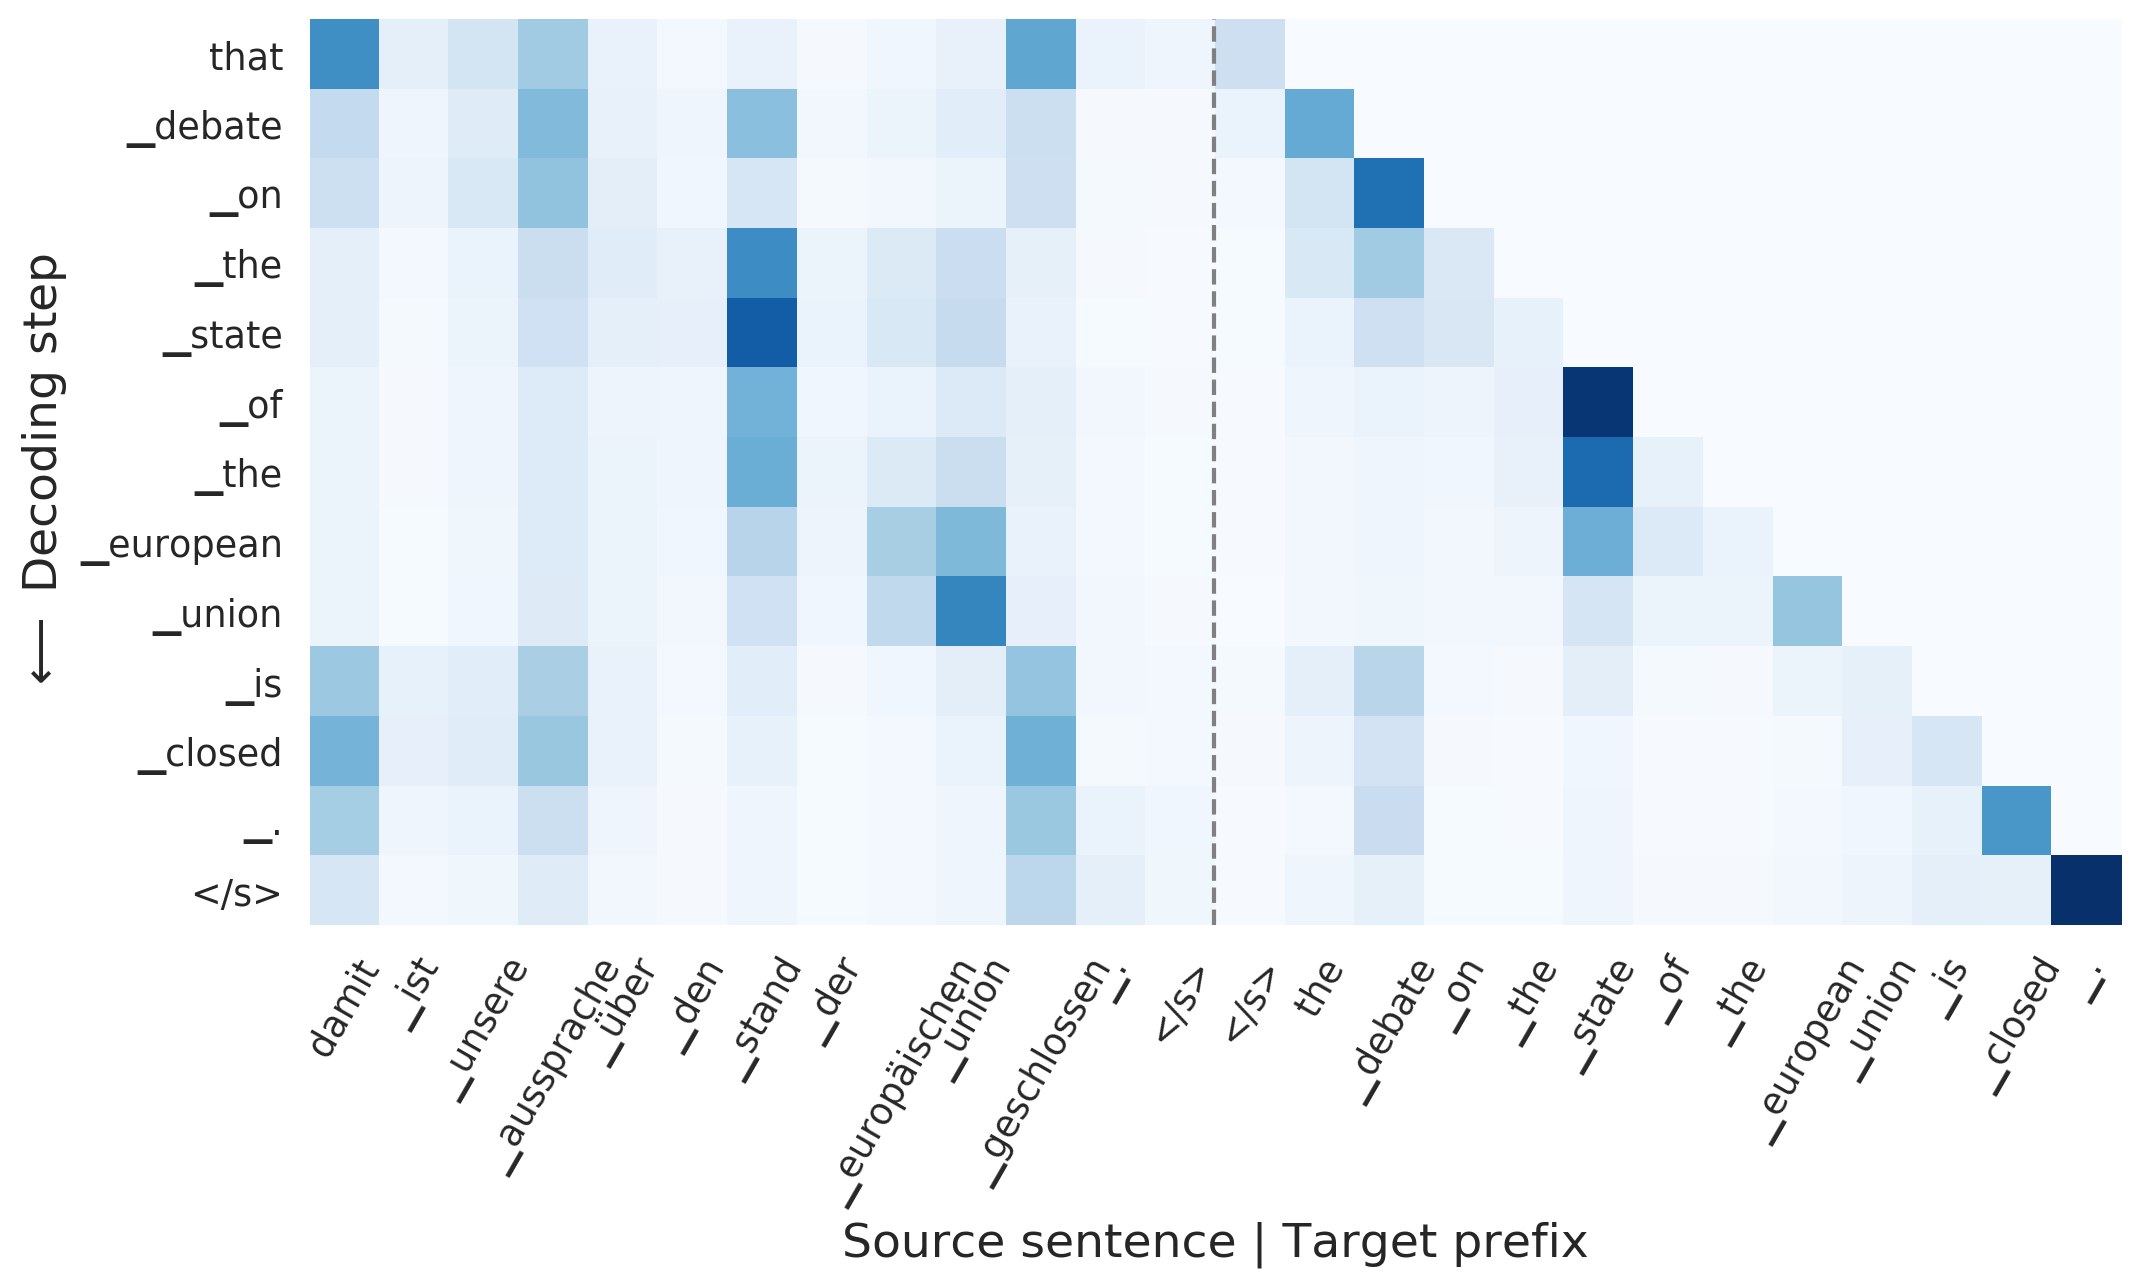

In [21]:
plt.figure(figsize=(15,6),dpi=200)
df = pd.DataFrame(contributions_rollout_layer_np, columns = source_sentence + ['</s>'] + ['</s>'] + target_sentence, index = predicted_sentence + ['</s>'])
sns.set(font_scale=1.2)
s = sns.heatmap(df,cmap="Blues",square=True, cbar=False)
s.set_xlabel('Source sentence | Target prefix', fontsize=17)
s.set_ylabel('$\longleftarrow$ Decoding step', fontsize=17)
plt.axvline(x = len(source_sentence)+0.98, lw=1.5, linestyle = '--', color = 'grey')# ymin = 0, ymax = 15
plt.xticks(rotation=60);


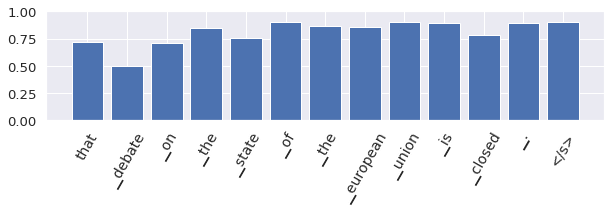

In [20]:
plt.figure(figsize=(10,2))

df_pred = pd.DataFrame(pred.values, columns = ['probability'], index = predicted_sentence + ['</s>'])
#sns.set_style("white")
plt.bar(range(0,len(predicted_sentence + ['</s>'])), df_pred.probability, align='center')
plt.xticks(ticks = range(0,len(predicted_sentence + ['</s>'])) ,labels = predicted_sentence + ['</s>'],fontsize='14',rotation=60)
#plt.gca().invert_yaxis()
plt.grid(visible=True)
plt.ylim(0,1);